In [1]:
import coffea.util as cu
import pandas as pd
import numpy as np
import sys
sys.path.append('/vols/cms/yhe4823/TopSBI/Functions')
from OpenFiles import extract_dataframes
from Plotting import inital_distributions_plot, stacked_hist, heat_map, heat_map1, eff_plot

In [2]:
sys.path.append("/vols/cms/yhe4823/PocketCoffea_top")
from pocket_coffea.parameters.lumi import lumi

In [3]:
for year, val in lumi.items():
    print(f"{year}: {val['tot']} fb⁻¹")

2016_PreVFP: 19648.186119 fb⁻¹
2016_PostVFP: 16977.701784 fb⁻¹
2017: 41479.680528 fb⁻¹
2018: 59832.47534 fb⁻¹
2022: 9600 fb⁻¹
2022_postEE: 27700 fb⁻¹
2023: 26500 fb⁻¹


In [16]:
for year, val in lumi.items():
    print(f"{year}: {val['tot'] * 1e-3:.1f} fb⁻¹")

2016_PreVFP: 19.6 fb⁻¹
2016_PostVFP: 17.0 fb⁻¹
2017: 41.5 fb⁻¹
2018: 59.8 fb⁻¹
2022: 9.6 fb⁻¹
2022_postEE: 27.7 fb⁻¹
2023: 26.5 fb⁻¹


In [10]:
data = cu.load("/vols/cms/yhe4823/TopSBI/Resolved/output_test/output_all.coffea")

In [ ]:
lumi_values = []

# Iterate over the years in 'by_datataking_period'
for year1 in data["datasets_metadata"]['by_datataking_period'].keys():
    # Compare with each year in 'lumi'
    for year, var in lumi.items():
        if year1 == year:  # Correct comparison operator (==)
            # Append the luminosity (converted to fb⁻¹) as a float
            lumi_values.append(var['tot'] * 1e-3)

print(lumi_values)


In [11]:
df, df_dict = extract_dataframes(data)
df_hadronic = df_dict.get("TTToHadronic_TTToHadronic_2018_baseline", None)
df_semileptonic = df_dict.get("TTToSemiLeptonic_TTToSemiLeptonic_2018_baseline", None)
df_leptonic = df_dict.get("TTTo2L2Nu_TTTo2L2Nu_2018_baseline", None)

Variables are:  dict_keys(['sum_genweights', 'sum_signOf_genweights', 'sumw', 'sumw2', 'cutflow', 'variables', 'columns', 'processing_metadata', 'datasets_metadata'])
Channels are: dict_keys(['TTToHadronic', 'TTTo2L2Nu', 'TTToSemiLeptonic'])
Processing datasets: TTToHadronic
  TTToHadronic_2018
    baseline
Processing datasets: TTTo2L2Nu
  TTTo2L2Nu_2018
    baseline
Processing datasets: TTToSemiLeptonic
  TTToSemiLeptonic_2018
    baseline


In [12]:
datasets = {
    'SemiLeptonic': df_semileptonic,
    'Leptonic': df_leptonic,
    'Hadronic': df_hadronic
}

In [ ]:
inital_distributions_plot(datasets)

In [4]:
import matplotlib.pyplot as plt
import mplhep as hep

def setup_plot():
    """
    Helper function to set up a consistent plot style for all plots,
    using a manual CMS-style label.
    
    Returns:
        fig, ax: The figure and axis objects.
    """
    # Use CMS style
    hep.style.use("CMS")
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Manually add CMS-style label at the top left (adjust coords as needed)
    ax.text(
        0, 1.02,
        "Private work (CMS simulation)", fontsize=18,
        style='italic', transform=ax.transAxes
    )

    return fig, ax


In [18]:
def get_lumi_display(year):
    """
    Returns a formatted luminosity string for a given year or Run period.

    Parameters:
        year (str): The data-taking year or 'Run2'/'Run3'.
        lumi (dict): Dictionary containing luminosity values with 'tot' key.

    Returns:
        str: Formatted luminosity string.
    """
    run2_years = ["2016_PreVFP", "2016_PostVFP", "2017", "2018"]
    run3_years = ["2022", "2022_postEE", "2023"]

    if year in run2_years and year in lumi and 'tot' in lumi[year]:
        lumi_value = lumi[year]['tot'] * 1e-3
        return f"{lumi_value:.1f} fb⁻¹ (13TeV)"
    
    elif year in run3_years and year in lumi and 'tot' in lumi[year]:
        lumi_value = lumi[year]['tot'] * 1e-3
        return f"{lumi_value:.1f} fb⁻¹ (13.6TeV)"
    
    elif year == "Run2":
        total_lumi = sum(lumi[y]['tot'] for y in run2_years if y in lumi and 'tot' in lumi[y]) * 1e-3
        return f"{total_lumi:.1f} fb⁻¹ (13TeV)"
    
    elif year == "Run3":
        total_lumi = sum(lumi[y]['tot'] for y in run3_years if y in lumi and 'tot' in lumi[y]) * 1e-3
        return f"{total_lumi:.1f} fb⁻¹ (13.6TeV)"
    
    else:
        return f"Unknown Lumi for {year}"


In [19]:
def stacked_hist(datasets, column_name, year, xlim_upper=None, bins=100, drop_zeros=False, xlim_lower=0):
    """
    Plots a stacked histogram for the specified column from the datasets, with CMS styling.
    """
    # Convert single DataFrame to a dictionary if necessary
    if isinstance(datasets, pd.DataFrame):
        datasets = {'Dataset': datasets}
        
    fig, ax = setup_plot()

    data_for_stack = []
    labels = list(datasets.keys())
    global_max = -float('inf')  # For automatic xlim_upper

    for name, df in datasets.items():
        if column_name in df.columns:
            data = df[column_name].dropna()
            if drop_zeros:
                data = data[data != 0]
            # Clip by lower bound only for now
            data = data[data >= xlim_lower]
            if xlim_upper is None:
                if not data.empty:
                    global_max = max(global_max, data.max())
            else:
                data = data[data <= xlim_upper]
            data_for_stack.append(data)
        else:
            print(f"Warning: Column '{column_name}' not found in dataset '{name}'")

    # Set xlim_upper automatically if it was None
    if xlim_upper is None:
        xlim_upper = global_max if global_max != -float('inf') else xlim_lower + 1  # fallback to prevent crash

    # Plot the stacked histogram
    plt.hist(data_for_stack, bins=bins, stacked=True, label=labels, edgecolor=None, alpha=1)

    plt.xlabel(column_name, fontsize=16)
    plt.ylabel("Counts", fontsize=16)
    plt.xlim([xlim_lower, xlim_upper])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

    plt.legend(title=None, fontsize=12, loc='upper right')
    plt.grid(True)

    lumi_display = get_lumi_display(year)

    # Add year and luminosity annotation to the top right
    plt.text(0.99, 1.01, lumi_display, transform=ax.transAxes, fontsize=18, verticalalignment='bottom', 
             horizontalalignment='right', style='italic', color='black')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_3766556/1809838367.py:64: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) TeX Gyre Heros.
  plt.tight_layout()
/home/hep/yh4823/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) TeX Gyre Heros.
  fig.canvas.print_figure(bytes_io, **kw)


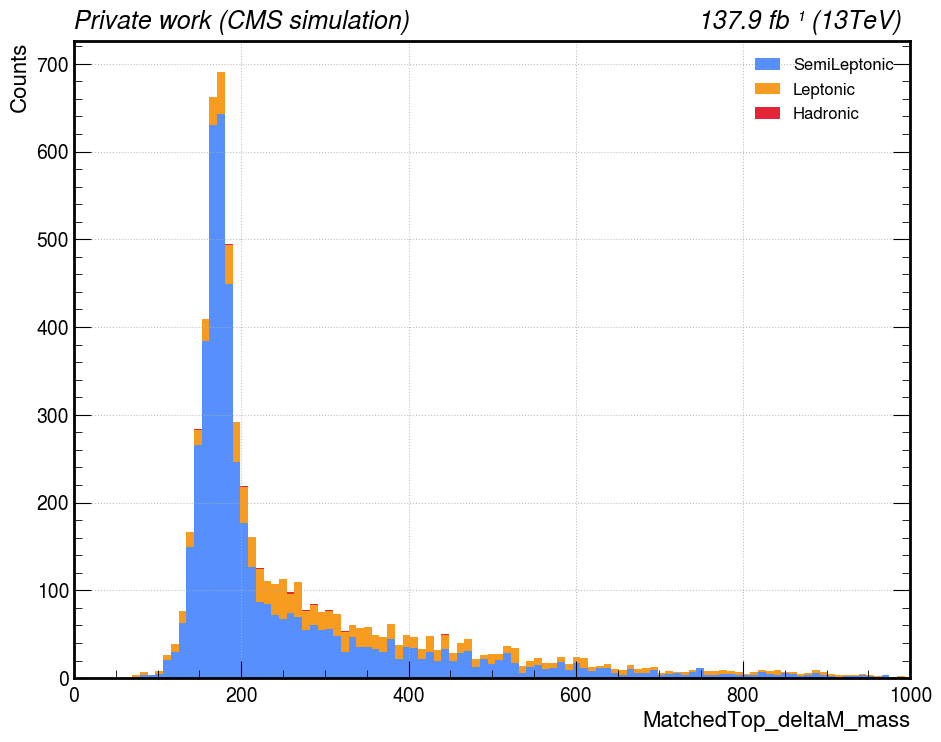

In [20]:
stacked_hist(datasets, column_name="MatchedTop_deltaM_mass", year = "Run2", xlim_upper=1000)

In [24]:
from matplotlib.colors import Normalize

In [37]:
def heat_map(datasets, var1, var2, xlim, ylim, year, bins=100):
    """
    Plots a 2D heatmap where each bin along var1 (x-axis, quantile bins) is normalized to 1 over var2 (y-axis, linear bins).
    Drops zero values from both variables.
    """

    # Support both dict and single DataFrame
    if isinstance(datasets, dict):
        x = np.concatenate([df[var1].dropna() for df in datasets.values()])
        y = np.concatenate([df[var2].dropna() for df in datasets.values()])
    else:
        x = datasets[var1].dropna().values
        y = datasets[var2].dropna().values

    # Drop zero values from both arrays
    nonzero_mask = (x != 0) & (y != 0)
    x = x[nonzero_mask]
    y = y[nonzero_mask]

    # Quantile-based bins for var1 (x-axis)
    quantile_bins = np.quantile(x, np.linspace(0, 1, bins + 1))

    # Linear bins for var2 (y-axis)
    linear_bins = np.linspace(y.min(), y.max(), bins + 1)

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=[quantile_bins, linear_bins])

    # Normalize each column (bin of var1) to sum to 1
    hist_normalized = hist / np.maximum(hist.sum(axis=1, keepdims=True), 1e-9)

    # Plot
    fig, ax = setup_plot()

    X, Y = np.meshgrid(yedges, xedges)
    pcm = ax.pcolormesh(X, Y, hist_normalized, cmap="Blues", norm=Normalize(vmin=0, vmax=hist_normalized.max()))

    cbar = plt.colorbar(pcm, ax=ax)
    cbar.set_label("Normalized Density per Quantile $p_{T}$ Bin", fontsize=16)
    cbar.ax.tick_params(labelsize=14)

    lumi_display = get_lumi_display(year)

    # Add year and luminosity annotation to the top right
    plt.text(0.99, 1.01, lumi_display, transform=ax.transAxes, fontsize=18, verticalalignment='bottom', 
             horizontalalignment='right', style='italic', color='black')

    ax.set_xlim(ylim)  # var2
    ax.set_ylim(xlim)  # var1
    ax.set_xlabel(f"{var2}", fontsize=16)
    ax.set_ylabel(f"{var1}", fontsize=16)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3766556/2287555170.py:53: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) TeX Gyre Heros.
  plt.tight_layout()


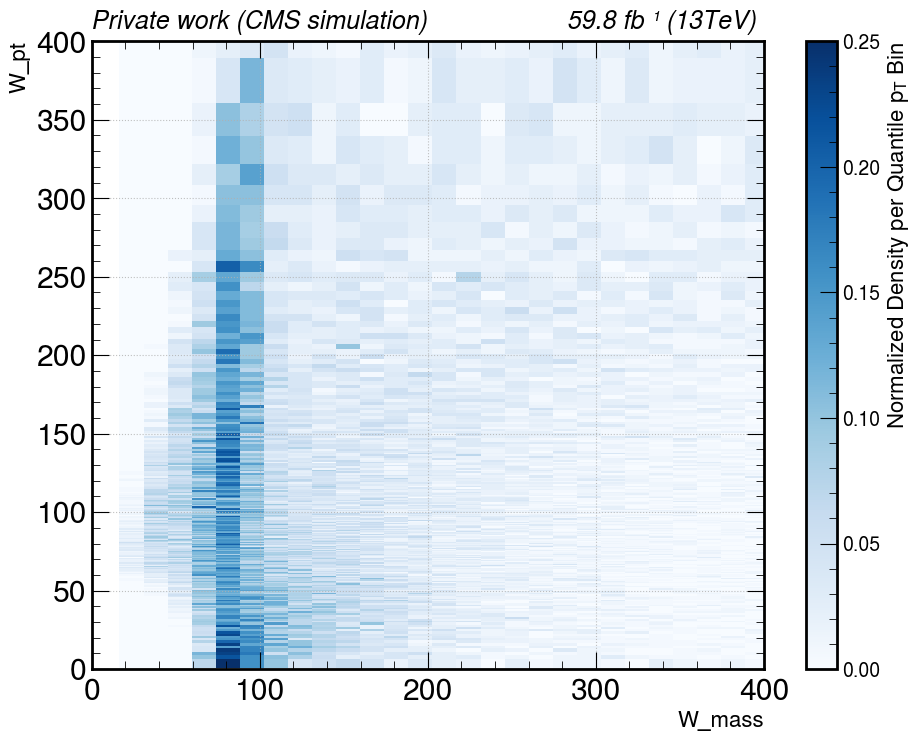

In [38]:
heat_map1(
    datasets,
    "W_pt",
    "W_mass",
    (0, 400), 
    (0, 400),
    year="2018", bins=200
)

In [39]:
def eff_plot(df, var1, var2, bins=10, year="2018 (13 TeV)"):
    """
    Plot the selection or generator-level matching efficiency as a function of transverse momentum,
    including binomial uncertainties.

    Parameters:
    - df: DataFrame (Semileptonic dataset)
    - var1: str, matched variable
    - var2: str, gen-level variable
    - bins: int, number of histogram bins (default = 10)
    - upper_lim: float or None, upper limit for the x-axis (auto from data if None)
    - year: str, annotation for the plot
    """

    # Set CMS plotting style
    hep.style.use("CMS")
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.cms.text("Private Work", ax=ax, fontsize=16)

    # Define variable names for transverse momentum and mass
    pt_field_matched = f"{var1}_pt"
    pt_field_gen = f"{var2}_pt"

    # Select valid entries
    pt_matched = df[df[pt_field_matched] > 0][pt_field_matched]
    pt_gen = df[df[pt_field_gen] > 0][pt_field_gen]
    # print(pt_matched)
    # print(pt_gen)
    print(len(pt_matched))
    print(len(pt_gen))

    min_pt = min(pt_matched.min(), pt_gen.min())
    max_pt = max(pt_matched.max(), pt_gen.max())

    # Define histogram bins
    bin_edges = np.linspace(min_pt, max_pt, bins + 1)

    # Histogram both matched and gen-level transverse momentum
    matched_counts, _ = np.histogram(pt_matched, bins=bin_edges)
    gen_counts, _ = np.histogram(pt_gen, bins=bin_edges)

    print(f"Bin edges: {bin_edges}")
    print(f"Matched counts: {matched_counts}")
    print(f"Gen counts: {gen_counts}")

    # Efficiency and uncertainty
    efficiency = np.divide(
        matched_counts, gen_counts,
        out=np.zeros_like(matched_counts, dtype=float),
        where=(gen_counts > 0) & (matched_counts > 0)
    )
    print(efficiency)
    
    uncertainty = np.sqrt(efficiency * (1 - efficiency) / gen_counts)
    uncertainty[gen_counts == 0] = 0

    # Bin centers and widths
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = (bin_edges[1:] - bin_edges[:-1]) / 2

    # Plot with error bars
    ax.errorbar(
        bin_centers, efficiency, yerr=uncertainty, xerr=bin_widths,
        fmt='o', label="Gen-Match Efficiency", capsize=2
    )
    ax.plot(bin_centers, efficiency, linestyle='-', color='C0')

    # Annotate max efficiency
    if np.any(efficiency):
        max_idx = np.argmax(efficiency)
        max_pt = bin_centers[max_idx]
        max_eff = efficiency[max_idx]
        ax.text(
            0.05, 0.9,
            f"Max efficiency:\n({max_pt:.1f}, {max_eff:.3f})",
            transform=ax.transAxes,
            fontsize=12,
            ha='left',
            va='top',
            color='red'
        )

    # Labels, grid, etc.
    ax.set_xlabel(r"$p_T$ [GeV]", fontsize=14)
    ax.set_ylabel("Efficiency", fontsize=14)
    # ax.set_xlim(0, upper_lim)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True)
    ax.legend(fontsize=12, loc='upper left', frameon=False)
    ax.text(
        0.99, 1.01, year,
        transform=ax.transAxes,
        fontsize=16,
        style='italic',
        ha='right',
        va='bottom'
    )

    plt.tight_layout()
    plt.show()


In [69]:
def eff_plot(df, var1, var2, bins=10, year="2018"):
    """
    Plot matching efficiency as a function of gen-level transverse momentum.
    
    Efficiency is defined as:
        (# gen objects with a match in var1) / (# total gen objects) in each pt bin.
    """

    # Set style
    fig, ax = setup_plot()

    # Field names
    pt_gen = df[f"{var2}_pt"]
    pt_matched = df[f"{var1}_pt"]

    # Mask for valid gen entries
    gen_mask = pt_gen > 0
    pt_gen = pt_gen[gen_mask]
    pt_matched = pt_matched[gen_mask]

    # Define matched (nonzero pt) entries
    matched_mask = pt_matched > 0

    # Histogram bins based on gen pt range
    min_pt = pt_gen.min()
    max_pt = pt_gen.max()
    bin_edges = np.linspace(min_pt, max_pt, bins + 1)

    # Bin gen entries
    gen_counts, _ = np.histogram(pt_gen, bins=bin_edges)

    # Bin only those gen entries which have a match
    matched_counts, _ = np.histogram(pt_gen[matched_mask], bins=bin_edges)

    # Efficiency
    efficiency = np.divide(
        matched_counts, gen_counts,
        out=np.zeros_like(matched_counts, dtype=float),
        where=gen_counts > 0
    )
    uncertainty = np.sqrt(efficiency * (1 - efficiency) / gen_counts)
    uncertainty[gen_counts == 0] = 0

    # Bin centers and widths
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = (bin_edges[1:] - bin_edges[:-1]) / 2

    # Plot
    ax.errorbar(
        bin_centers, efficiency, yerr=uncertainty, xerr=bin_widths,
        fmt='o', label="Gen-Match Efficiency", capsize=2
    )
    ax.plot(bin_centers, efficiency, linestyle='-', color='C0')

    # Annotate max
    if np.any(efficiency):
        max_idx = np.argmax(efficiency)
        ax.text(
            0.03, 0.92,
            f"Max efficiency at ({bin_centers[max_idx]:.1f}, {efficiency[max_idx]:.1f})",
            transform=ax.transAxes,
            fontsize=14,
            ha='left',
            va='top',
            color='red'
        )

    ax.set_xlabel(r"$p_T^{\mathrm{gen}}$", fontsize=16)
    ax.set_ylabel("Efficiency", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12, loc='upper left', frameon=False)

    lumi_display = get_lumi_display(year)

    # Add year and luminosity annotation to the top right
    plt.text(0.99, 1.01, lumi_display, transform=ax.transAxes, fontsize=18, verticalalignment='bottom', 
             horizontalalignment='right', style='italic', color='black')


    plt.tight_layout()
    plt.show()


/tmp/ipykernel_3766556/2447463696.py:41: RuntimeWarning: invalid value encountered in divide
  uncertainty = np.sqrt(efficiency * (1 - efficiency) / gen_counts)
/tmp/ipykernel_3766556/2447463696.py:80: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) TeX Gyre Heros.
  plt.tight_layout()


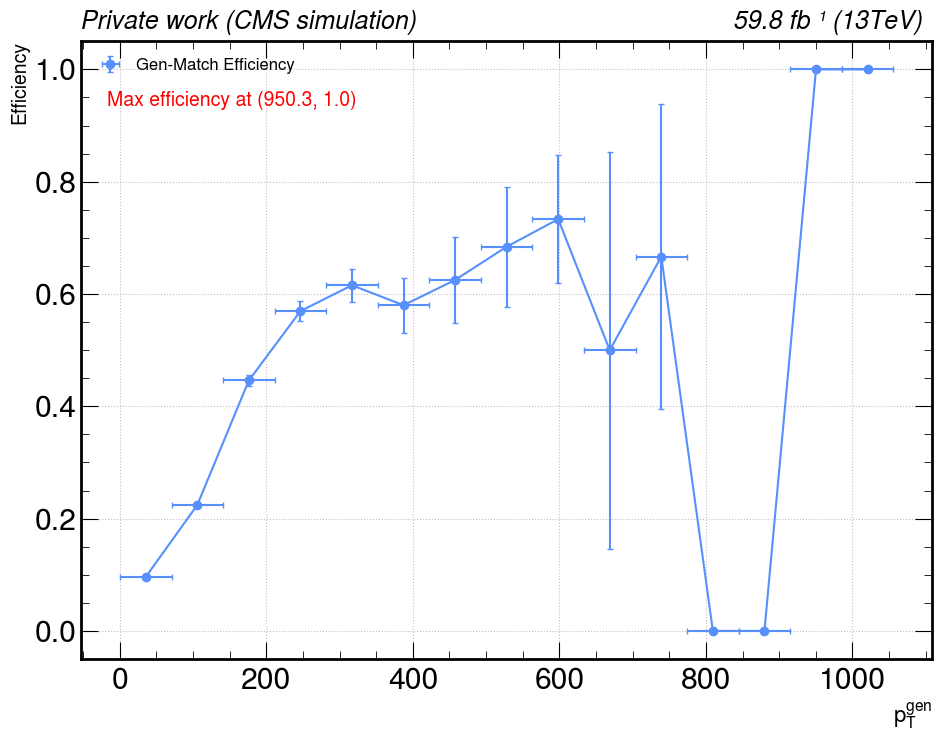

In [73]:
eff_plot(df_semileptonic, "MatchedW", "GenW", 15, "2018")

In [41]:
def reco_eff_plot(df, var1, var2, bins=10, year="2018 (13 TeV)"):
    """
    Plot matching efficiency as a function of reco-level transverse momentum.
    
    Efficiency is defined as:
        (# reco objects that are matched to a gen object) / 
        (# total reco objects) in each reco pt bin.
    """
    # Set style
    hep.style.use("CMS")
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.cms.text("Private Work", ax=ax, fontsize=16)

    # Reco and gen pt
    pt_reco = df[f"{var1}_pt"]
    pt_gen = df[f"{var2}_pt"]

    # Define valid reco objects (e.g. reco pt > 0)
    reco_mask = pt_reco > 0
    pt_reco = pt_reco[reco_mask]
    pt_gen = pt_gen[reco_mask]

    # Define which reco objects are matched (i.e. corresponding gen pt > 0)
    matched_mask = pt_gen > 0

    # Define binning in pt_reco
    min_pt = pt_reco.min()
    max_pt = pt_reco.max()
    bin_edges = np.linspace(min_pt, max_pt, bins + 1)

    # Denominator: total reco objects per bin
    total_counts, _ = np.histogram(pt_reco, bins=bin_edges)

    # Numerator: matched reco objects per bin
    matched_counts, _ = np.histogram(pt_reco[matched_mask], bins=bin_edges)

    # Compute efficiency and uncertainty
    efficiency = np.divide(
        matched_counts, total_counts,
        out=np.zeros_like(matched_counts, dtype=float),
        where=total_counts > 0
    )
    uncertainty = np.sqrt(efficiency * (1 - efficiency) / total_counts)
    uncertainty[total_counts == 0] = 0

    # Bin centers and widths
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = (bin_edges[1:] - bin_edges[:-1]) / 2

    # Plot
    ax.errorbar(
        bin_centers, efficiency, yerr=uncertainty, xerr=bin_widths,
        fmt='o', label="Reco-Match Efficiency", capsize=2
    )
    ax.plot(bin_centers, efficiency, linestyle='-', color='C1')

    # Annotate max
    if np.any(efficiency):
        max_idx = np.argmax(efficiency)
        ax.text(
            0.05, 0.9,
            f"Max efficiency:\n({bin_centers[max_idx]:.1f}, {efficiency[max_idx]:.3f})",
            transform=ax.transAxes,
            fontsize=12,
            ha='left',
            va='top',
            color='red'
        )

    ax.set_xlabel(r"$p_T^{\mathrm{reco}}$ [GeV]", fontsize=14)
    ax.set_ylabel("Matching Efficiency", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12, loc='upper left', frameon=False)
    ax.text(
        0.99, 1.01, year,
        transform=ax.transAxes,
        fontsize=16,
        style='italic',
        ha='right',
        va='bottom'
    )

    plt.tight_layout()
    plt.show()


In [ ]:
reco_eff_plot(df_semileptonic, "MatchedW", "GenW", 15)

In [ ]:
eff_plot(df_semileptonic, "MatchedW", "GenW", 15)

In [ ]:
reco_eff_plot(df_semileptonic, "MatchedTop_deltaM", "GenTop_deltaM", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedTop_deltaM", "GenTop_deltaM", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedTop_deltaM", "GenTop_deltaM", 20)

In [ ]:
inital_distributions_plot(datasets)

In [ ]:
eff_plot(df_semileptonic, "MatchedGenW", "GenW", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedW", "GenW", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedGenTop_deltaR", "GenTop_deltaR", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedTop_deltaR", "GenTop_deltaR", 20)

In [ ]:
def eff_plot(df, var1, var2, bins=10, year="2018 (13 TeV)"):
    """
    Plot the selection or generator-level matching efficiency as a function of transverse momentum,
    including binomial uncertainties.

    Parameters:
    - df: DataFrame (Semileptonic dataset)
    - var1: str, matched variable
    - var2: str, gen-level variable
    - bins: int, number of histogram bins (default = 10)
    - year: str, annotation for the plot
    """

    # Set CMS plotting style
    hep.style.use("CMS")
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.cms.text("Private Work", ax=ax, fontsize=16)

    # Define variable names for transverse momentum and mass
    pt_field_matched = f"{var1}_pt"
    mass_field_matched = f"{var1}_mass"
    pt_field_gen = f"{var2}_pt"
    mass_field_gen = f"{var2}_mass"

    # # Filter out outlier values only for var1 (matched variable)
    # df = df[(df[f"{var1}_mass"] != -0.999)]

    # Select valid entries (matching positive mass and pt)
    pt_matched = [pt for m, pt in zip(df[mass_field_matched], df[pt_field_matched]) if m > 0 and pt > 0]
    pt_gen = [pt for m, pt in zip(df[mass_field_gen], df[pt_field_gen]) if m > 0 and pt > 0]

    upper_lim = upper_lim = max(max(pt_gen), max(pt_matched)) * 1.1  # Find max of both lists and add 10% padding

    # Define histogram bins
    bin_edges = np.linspace(0, upper_lim, bins + 1)

    # Histogram both matched and gen-level transverse momentum
    matched_counts, _ = np.histogram(pt_matched, bins=bin_edges)
    gen_counts, _ = np.histogram(pt_gen, bins=bin_edges)

    print(f"Bin edges: {bin_edges}")
    print(f"Matched counts: {matched_counts}")
    print(f"Gen counts: {gen_counts}")

    # Efficiency and uncertainty
    efficiency = np.divide(
        matched_counts, gen_counts,
        out=np.zeros_like(matched_counts, dtype=float),
        where=(gen_counts > 0) & (matched_counts > 0)
    )
    print(efficiency)
    
    uncertainty = np.sqrt(efficiency * (1 - efficiency) / gen_counts)
    uncertainty[gen_counts == 0] = 0

    # Bin centers and widths
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = (bin_edges[1:] - bin_edges[:-1]) / 2

    # Plot with error bars
    ax.errorbar(
        bin_centers, efficiency, yerr=uncertainty, xerr=bin_widths,
        fmt='o', label="Gen-Match Efficiency", capsize=2
    )
    ax.plot(bin_centers, efficiency, linestyle='-', color='C0')

    # Annotate max efficiency
    if np.any(efficiency):
        max_idx = np.argmax(efficiency)
        max_pt = bin_centers[max_idx]
        max_eff = efficiency[max_idx]
        ax.text(
            0.05, 0.9,
            f"Max efficiency:\n({max_pt:.1f}, {max_eff:.3f})",
            transform=ax.transAxes,
            fontsize=12,
            ha='left',
            va='top',
            color='red'
        )

    # Labels, grid, etc.
    ax.set_xlabel(r"$p_T$ [GeV]", fontsize=14)
    ax.set_ylabel("Efficiency", fontsize=14)
    ax.set_xlim(0, upper_lim)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True)
    ax.legend(fontsize=12, loc='upper left', frameon=False)
    ax.text(
        0.99, 1.01, year,
        transform=ax.transAxes,
        fontsize=16,
        style='italic',
        ha='right',
        va='bottom'
    )

    plt.tight_layout()
    plt.show()


In [ ]:
eff_plot(df_semileptonic, "MatchedTop_deltaR", "GenTop_deltaR", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedGenW", "GenW", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedW", "GenW", 20)

In [ ]:
df_semileptonic['MatchedGenTop_deltaR_mass']

In [ ]:
df_semileptonic['GenTop_deltaR_mass']

In [ ]:
eff_plot(df_semileptonic, "MatchedGenTop_deltaR", "GenTop_deltaR", 20)

In [ ]:
eff_plot(df_semileptonic, "MatchedTop_deltaR", "GenTop_deltaR", 20)